In [1]:
import sys
import os
from tkinter import EXCEPTION
sys.path.append('./includes')
import numpy as np
import matplotlib.pyplot as plt
import random
from numpy.linalg import norm
from math import sqrt, pow, ceil
from numba import njit

from tqdm import tqdm

# import ray
# ray.init()

from includes.constants import *
from includes.calculations import *
# from includes.gpu_calculations import *
from includes.plotting import *

In [2]:
!rm *.csv *.xyz

In [3]:
def set_seed(seed=42):
    '''
    
    Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.

    '''
    np.random.seed(seed)
    random.seed(seed)
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(30)

In [4]:
np.random.seed(42)

# Because temperature is an average kinetic energy of CHAOTIC movement, I'll need to substract
# the speed of center of mass from the speed of every atom to calculate the temperature


def main_cycle(spawn_on_grid=True, sigma_for_vel=False, verbose=1, bins_num=50, averaging_part=0.8, writing_step=1, device='CPU',
    coords_path='coords.csv', forces_path='forces.csv', vel_path='velocities.csv',
    boundary_conditions=True, boundary_conditions_teleportation=True, velocity_scaler=None):
    '''

    main cycle, all the movements and calculations will happen here
    verbose: % of program finished to print
    diffusion_step: once every diffusion_step all coordinates will be written for diffusion plotting
    rho = 1 / rho_coef ** 3

    boundary_conditions: овтечает за выбор частиц из других клеток при расчете сил, ЗСЭ при этом не будет выполняться, False ставим чтобы получить F(r), тогда частицы могут бешено разогнаться

    boundary_conditions_teleportation: отвечает за 'телепортацию' частицы к противоположному краю клетки, чтобы все было норм с ЗСЭ надо оба включать

    velocity_scaler: указываем температуру к которой скейлить
    
    '''
    if str(N) not in coords_path.split('.')[0] or str(N) not in forces_path.split('.')[0]:
        raise Exception('Writing into the wrong file (amount of particles)')

    particles = initialize_system(on_grid=spawn_on_grid, sigma_for_velocity=sigma_for_vel, device=device)
    total_pot = 0
    total_kin = 0
    #---
    energies = np.array([])
    kins = np.array([])
    pots = np.array([])
    #---
    coord_writer, force_writer, vel_writer = create_coords_and_forces_writer(coords_path=coords_path, forces_path=forces_path, vel_path=vel_path)
    steps_of_averaging = int(averaging_part * TIME_STEPS)
    #---
    for ts in range(TIME_STEPS):
        write_first_rows_in_files()
        total_pot = 0
        total_kin = 0
        #-----moving---------
        for p in particles:
            p.move(boundary_conditions_teleportation)
            p.kin_energy = 0.5 * norm(p.vel) ** 2
            write_into_the_files(p)
            p.vel = p.vel + 0.5 * p.acc * dt # adding 1/2 * a(t) * dt
            p.acc = np.zeros(3)
            p.pot_energy = 0
        for i in range(N):
            for j in range(i + 1, N):
                calculate_acceleration(particles[i], particles[j], boundary_conditions)
        for p in particles:
            total_kin += p.kin_energy
            total_pot += p.pot_energy
            p.vel += 0.5 * p.acc * dt   # adding 1/2 * a(t + dt)
        #---

        # energies = np.append(energies, total_kin + total_pot)
        # kins = np.append(kins, total_kin)
        # pots = np.append(pots, total_pot)      
        T_current = (2 / 3) * (total_kin) / N

        if velocity_scaler:
            for p in particles:
                p.vel *= sqrt(velocity_scaler / T_current)

        # Starting things for a set conditions:
        if (ts >= TIME_STEPS - steps_of_averaging) and (ts % writing_step == 0):

            write_coords_and_forces(particles=particles, time=ts * dt, coord_writer=coord_writer, force_writer=force_writer, vel_writer=vel_writer)

        #--------
        if int((0.01 * TIME_STEPS)) % verbose == 0:
            print(f'{ts} steps passed, Temp_current = {T_current}, K={total_kin}, U={total_pot}, E = {total_kin + total_pot}')
            
    return particles

In [5]:

# ---------------------------------------- #

particles = main_cycle(
        spawn_on_grid=True,
        
        sigma_for_vel=0.0,
        
        bins_num=170, 
        
        averaging_part=0.95,

        
        writing_step=1,

        boundary_conditions=boundary_conditions,  # False, если хотим просто силы записывать - это boundary conditions на вычисление потенциальной энергии
        boundary_conditions_teleportation=boundary_conditions_teleportation,     # Если скейлер ставить и здесь True, то никто очень сильно не разгонится
        # velocity_scaler=0.5,

        coords_path=f'coords{N}.csv',
        forces_path=f'forces{N}.csv',
        vel_path=f'velocities{N}.csv',
        verbose=100
        )

        # False, True, 0.5 - типичная настройка для записи сил


# Для каждой частицы мы берем разные 'копии' других частиц из соседних клеток, поскольку выбор оптимальных соседей для каждой частицы из главной клетки свой, 
# поэтому все что нам остается - отключить периодические условия, поскольку иначе в одной конфигурации мы можем определить силы только для одной частицы

# Но их можно отключить хитро: поскольку нас волнует только зависимость F(\vec {r}), то можно оставить телепортацию частиц при выходе из клетки, но отключить выбор частиц из других клеток при расчете сил

[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
0 steps passed, Temp_current = 0.0, K=0.0, U=-1.1729495758990751, E = -1.1729495758990751
1 steps passed, Temp_current = 6.98500529107547e-09, K=4.1910031746452823e-08, U=-1.1729497016291808, E = -1.172949659719149
2 steps passed, Temp_current = 2.7940023413937237e-08, K=1.6764014048362343e-07, U=-1.172949911179403, E = -1.1729497435392626
3 steps passed, Temp_current = 6.286506111749288e-08, K=3.771903667049573e-07, U=-1.1729502045498084, E = -1.1729498273594416
4 steps passed, Temp_current = 1.1176012964992688e-07, K=6.705607778995613e-07, U=-1.1729505817404915, E = -1.1729499111797137
5 steps passed, Temp_current = 1.7462524475870809e-07, K=1.0477514685522486e-06, U=-1.1729510427515735, E = -1.172949995000105
6 steps passed, Temp_current = 2.5146042669060064e-07, K=1.508762560143604e-06, U=-1.1729515875832042, E = -1.172950078820644
7 steps passed, Temp_current = 3.422657001916776e-07, K=2.0535942011500656e-06, U=-1.172952216235557, E = -1

---

In [6]:
@njit
def pot_energy(r1, r2):
    # Snaps particle back to the unfolded coordinate
    r1 = r1 % L
    r2 = r2 % L
    r = r1 - r2
    for i in range(3):
        if np.abs(r[i]) > L / 2:   # Если расстояние между двумя частицами больше L/2, то мы точно найдем в соседних клетках ближе
            r[i] = r[i] - L * np.sign(r[i])

    d = norm(r)
    return -4 * (pow(d, -6) - pow(d, -12))

def plot_energy(N=N, path_coords=f"coords{N}.csv", path_vels=f"velocities{N}.csv"):
    E = []
    try:
        coords = pd.read_csv(path_coords).drop(columns=["t"])
        vels = pd.read_csv(path_vels).drop(columns=["t"])
    except:
        coords = pd.read_csv(path_coords)
        vels = pd.read_csv(path_vels)
    
    for row_n in tqdm(range(len(vels))):  # TODO: ЗДЕСЬ СТОИТ vels ПОТОМУ ЧТО У МЕНЯ ПОКА БАГА И В КООРДС НА ОДНУ СТРОЧКУ БОЛЬШЕ ПОЧЕМУ-ТО...
        V = 0
        T = 0
        for i in range(N):
            r_i = np.array(coords.iloc[row_n, (3 * i):(3 * i) + 3])

            for j in range(i + 1, N):
                r_j = np.array(coords.iloc[row_n, (3 * j):(3 * j) + 3])
                # print(r_i, r_j)
                V += pot_energy(r_i, r_j)
        

        T = ((vels.iloc[row_n]) ** 2).sum() / 2
        E.append(T + V)

        # print(
        #     f'{row_n}: K = {T}, V = {V}, E = {T + V}'
        # )

    plt.figure(figsize=(10, 10))
    plt.plot(
        [i for i in range(len(E))], E
    )

    avg_E = np.array(E).mean()

    # print(E)

    plt.ylim([-0.1 + avg_E, 0.1 + avg_E])
    # plt.xlabel()

100%|██████████| 9500/9500 [00:06<00:00, 1458.06it/s]


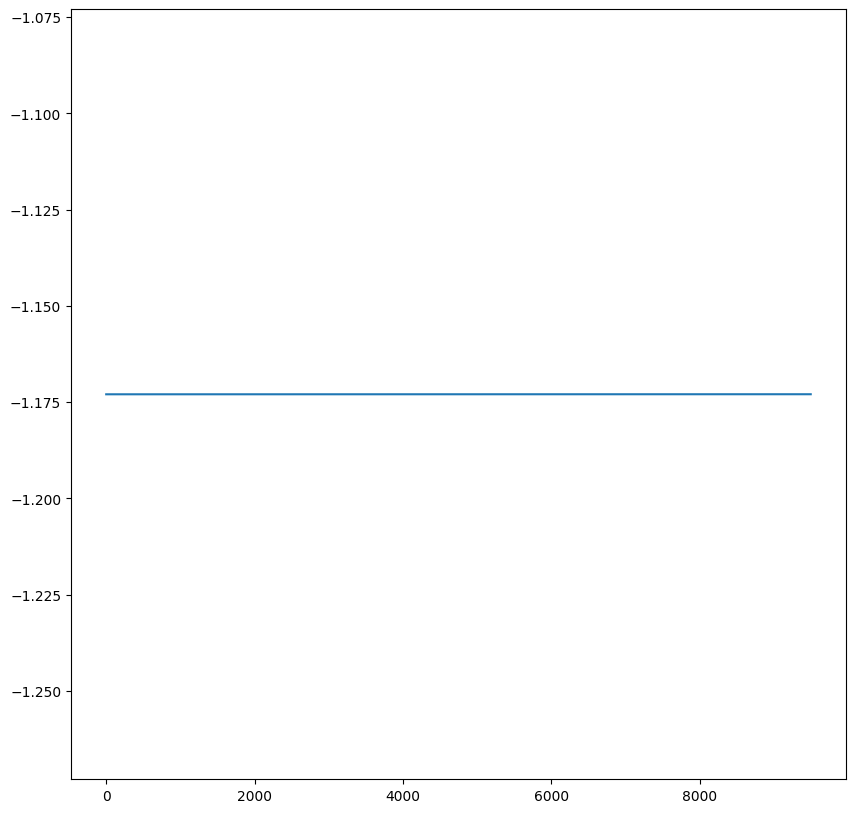

In [7]:
plot_energy(
    
)

In [8]:
r1 = particles[0].pos
r2 = particles[1].pos 

In [9]:
r1, r2

(array([3.00145193, 0.24046382, 0.0307678 ]),
 array([1.65034424, 3.10308643, 3.13304867]))

In [10]:
pot_energy(r1, r2)

-0.4801261853141816